# Modeling and Simulation in Python

Chapter 21

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [3]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    diameter, mass = params.diameter, params.mass
    g, rho = params.g, params.rho, 
    v_init, v_term = params.v_init, params.v_term
    height = params.height
    
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=height, v=v_init)
    t_end = 30 * s
    dt = t_end / 100
    
    return System(params, area=area, C_d=C_d, 
                  init=init, t_end=t_end, dt=dt)

Let's make a `System`

In [5]:
system = make_system(params)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.4445009981135434 dimensionless
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [6]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    y, v = state
    rho, C_d, g = system.rho, system.C_d, system.g
    area, mass = system.area, system.mass
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [7]:
slope_func(system.init, 0, system)

(0.0 <Unit('meter / second')>, -9.8 <Unit('meter / second ** 2')>)

We can use the same event function as in the previous chapter.

In [8]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [9]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


Here are the results.

In [10]:
results.head()

,y,v
0.0,381 meter,0.0 meter / second
0.3,380.559 meter,-2.913855777777778 meter / second
0.6,379.2553998560887 meter,-5.676321799192868 meter / second
0.9,377.15535917269835 meter,-8.166374221525693 meter / second
1.2,374.35521895425103 meter,-10.311720070623485 meter / second


In [11]:
results.tail()

,y,v
21.300000,20.486949941310563 meter,-17.99999999508715 meter / second
21.600000,15.086949942543686 meter,-17.99999999642989 meter / second
21.900000,9.686949943439785 meter,-17.99999999740564 meter / second
22.200000,4.286949944090969 meter,-17.999999998114706 meter / second
22.438164,0.0 meter,-17.99999999852377 meter / second


The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

We can get the flight time from `results`.

In [12]:
t_sidewalk = get_last_label(results) * s

22.438163885803732 <Unit('second')>

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


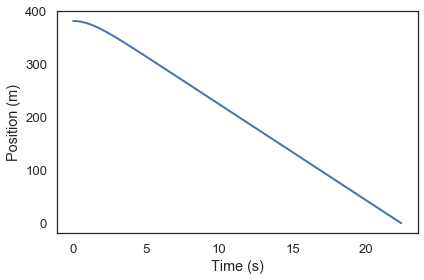

In [13]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

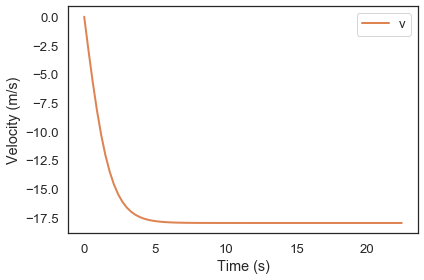

In [14]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: You can create a new `Params` object based on an existing one, like this:

`params2 = Params(params, v_init=-30 * m/s)`

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [15]:
# Solution

v_init = -30 * m / s
params2 = Params(params, v_init=v_init)

,values
height,381 meter
v_init,-30.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second


In [16]:
# Solution

system2 = make_system(params2)
results, details = run_ode_solver(system2, slope_func, events=event_func, max_step=0.5)
details.message

'A termination event occurred.'

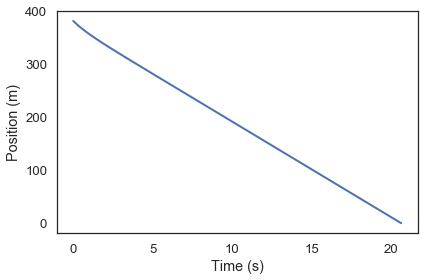

In [17]:
plot_position(results)

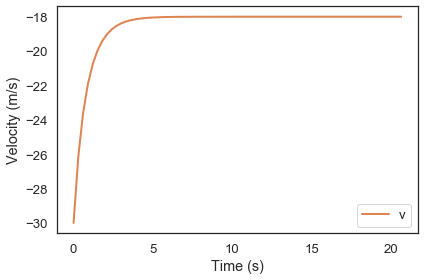

In [18]:
# Solution

plot_velocity(results)

**Exercise:** Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  Use this measurement to estimate the terminal velocity.

1. You can get the relevant dimensions of a quarter from https://en.wikipedia.org/wiki/Quarter_(United_States_coin).

2. Create a `Params` object with the system parameters.  We don't know `v_term`, so we'll start with the inital guess `v_term = 18 * m / s`.

3. Use `make_system` to create a `System` object.

4. Call `run_ode_solver` to simulate the system.  How does the flight time of the simulation compare to the measurement?

5. Try a few different values of `t_term` and see if you can get the simulated flight time close to 19.1 seconds.

6. Optionally, write an error function and use `root_scalar` to improve your estimate.

7. Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the observed flight time, so don't take the results of this exercise too seriously.

In [19]:
# Solution

# Here's a `Params` object with the dimensions of a quarter,
# the observed flight time and our initial guess for `v_term`

params3 = Params(params,
                 mass = 5.67e-3 * kg,
                 diameter = 24.26e-3 * m,
                 v_term = 18 * m / s,
                 flight_time = 19.1 * s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
flight_time,19.1 second


In [20]:
# Solution

# Now we can make a `System` object

system3 = make_system(params3)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
flight_time,19.1 second
area,0.000462244204111976 meter ** 2
C_d,0.6183600157463346 dimensionless


In [21]:
# Solution

# Run the simulation

results, details = run_ode_solver(system3, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


In [22]:
# Solution

# And get the flight time

flight_time = get_last_label(results) * s

22.438163885803736 <Unit('second')>

In [23]:
# Solution

# The flight time is a little long, so we could increase `v_term` and try again.

# Or we could write an error function

def error_func(guess, params):
    """Final height as a function of C_d.
    
    guess: guess at v_term
    params: Params object
    
    returns: height in m
    """
    print(guess)
    params = Params(params, v_term=guess)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    flight_time = get_last_label(results) * s
    error = flight_time - params.flight_time
    return magnitude(error)

In [24]:
# Solution

# We can test the error function like this
v_guess1 = 18 * m / s
error_func(v_guess1, params3)

18.0 meter / second


3.338163885803734

In [25]:
# Solution

v_guess2 = 22 * m / s
error_func(v_guess2, params3)

22.0 meter / second


-0.22714064382192944

In [26]:
# Solution

# Now we can use `root_scalar` to find the value of `v_term` that yields the measured flight time.

res = root_bisect(error_func, [v_guess1, v_guess2], params3)

18.0 meter / second
22.0 meter / second
20.0 meter / second
21.0 meter / second
21.5 meter / second
21.75 meter / second
21.625 meter / second
21.6875 meter / second
21.71875 meter / second
21.703125 meter / second
21.6953125 meter / second
21.69140625 meter / second
21.689453125 meter / second
21.6884765625 meter / second
21.68798828125 meter / second
21.687744140625 meter / second
21.6878662109375 meter / second
21.68792724609375 meter / second
21.687896728515625 meter / second
21.687881469726562 meter / second
21.68787384033203 meter / second
21.687877655029297 meter / second
21.68787956237793 meter / second


,values
converged,True
root,21.687878608703613 meter / second


In [27]:
# Solution

v_term_solution = res.root

21.687878608703613 <Unit('meter / second')>

In [28]:
# Solution

# Plugging in the estimated value, we can use `make_system` to compute `C_d`

params_solution = Params(params3, v_term=v_term_solution)
system = make_system(params_solution)
system.C_d

0.4259437619496639 <Unit('dimensionless')>